# Cursos de Series de tiempo con *Machine Learning*
## Modulo 20. Modelo de ARMA-SARMA-SARMAX

                        Elaborado por: Naren Castellon

## 📦 **Caso de Estudio: Forecasting de Pedidos y Precios en una Compañía de Delivery**

### 🧭 **Objetivo del Caso de Estudio**
Diseñar, ajustar y evaluar un modelo de pronóstico (forecasting) que permita anticipar el número de órdenes (`num_orders`) y la variabilidad de precios (`checkout_price`, `base_price`) en una empresa de delivery para:
- Optimizar la planificación de personal y logística.
- Mejorar la gestión de precios dinámicos.
- Estimar ingresos futuros con mayor precisión.

---

### 🛠️ **Caso de Uso**
Una empresa regional de delivery enfrenta fluctuaciones inesperadas en la demanda y los ingresos diarios. Los datos disponibles incluyen:
- Número diario de pedidos por zona.
- Precio base del producto.
- Precio final pagado (`checkout_price`), que incluye promociones o cargos dinámicos.
  
El equipo de datos busca construir un modelo de forecasting para anticipar pedidos y precios, de modo que se pueda:
- Ajustar el inventario en cocinas asociadas.
- Predecir los ingresos diarios.
- Identificar zonas o franjas horarias con comportamiento anómalo.

---

### 🧪 **Desarrollo del Caso**

#### 1. **Recolección de Datos**
Datos históricos por fecha, zona y tipo de orden:
- `order_date`
- `zone_id`
- `num_orders`
- `base_price`
- `checkout_price`

#### 2. **Análisis Exploratorio (EDA)**
- Correlación entre precios y número de pedidos.
- Estacionalidad semanal (más pedidos viernes/domingo).
- Tendencias de incremento de `checkout_price` en zonas con alta demanda.
- Outliers identificados durante eventos especiales (navidad, cyber monday).

#### 3. **Preprocesamiento**
- Imputación de valores faltantes en precios.
- Creación de nuevas variables: `discount = base_price - checkout_price`.
- Desagregación por zona y resampleo diario.

#### 4. **Modelo de Forecasting**
Se probaron varios modelos:
- **SARIMA/SARIMAX** para `num_orders` por zona, capturando estacionalidad semanal.
- **XGBoost Regressor** para `checkout_price`, utilizando features como:
  - día de la semana
  - precio base
  - número de toppings
  - clima (variable externa)

#### 5. **Evaluación**
- MAE y RMSE para cada modelo.
- Gráficos de residuos → autocorrelación controlada.
- Predicciones con intervalos de confianza.

---

### 💡 **Recomendaciones**
- Incorporar variables exógenas como clima, promociones especiales y feriados en el modelo.
- Utilizar `SARIMA`, `LightGBM`, `XGBoost` o `CatBoost` en producción por su robustez en crecimiento no lineal.
- Implementar alertas si los errores de predicción superan un umbral (por ejemplo, RMSE > 20%).

---

### ⚠️ **Consideraciones y Lecciones**
- La estacionalidad es crítica en operaciones de delivery, especialmente los fines de semana.
- Precios dinámicos afectan directamente la demanda: ajustar modelos cada mes puede mejorar la precisión.
- No todos los outliers deben eliminarse: algunos representan eventos de negocio reales (como promociones virales).
- La calidad de los datos (`base_price` mal registrado, timestamps duplicados) afecta más que el modelo elegido.

---

### 📈 **Resultados Esperados**
- Mejora en la predicción de demanda hasta un 18% (comparado con moving average).
- Ajustes en turnos de repartidores basados en demanda proyectada.
- Revisión del modelo de precios para minimizar descuentos innecesarios en días con alta demanda.


In [1]:
# Manipulación y procesamiento de Datos
# ==============================================================================
import pandas as pd
import numpy as np

# Plot - Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Utils
# ==============================================================================
from utilsforecast.plotting import plot_series
from utilsforecast.preprocessing import fill_gaps


# Define the plot size
# ==============================================================================
from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

# No presentar advertencia
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

In [2]:
meal = pd.read_csv('https://raw.githubusercontent.com/narencastellon/Serie-de-tiempo-con-Machine-Learning/refs/heads/main/Data/delivery_company-meal_info.csv')

train = pd.read_csv('https://github.com/narencastellon/Serie-de-tiempo-con-Machine-Learning/raw/refs/heads/main/Data/delivery_company-Train.csv')

test = pd.read_csv('https://raw.githubusercontent.com/narencastellon/Serie-de-tiempo-con-Machine-Learning/refs/heads/main/Data/delivery_company-test.csv')

#fc_df = pd.read_csv('/kaggle/input/food-demand-forecasting/fulfilment_center_info.csv')

In [3]:
#merging train and test sets to incorporate all features

train = train.merge(meal, on='meal_id',how='left')

test = test.merge(meal, on='meal_id',how='left')

In [4]:
train

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian
...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian


In [5]:
train.groupby('week')['num_orders'].sum()

week
1       792261
2       787084
3       695262
4       743529
5      1198675
        ...   
141     776240
142     739661
143     759926
144     801197
145     671926
Name: num_orders, Length: 145, dtype: int64

In [6]:
import matplotlib.pyplot as plt 

import seaborn as sns 

def plot_categoricals(df,category,agg_func): 

    fig, ax = plt.subplots(figsize=(18, 6))
    
    df_grouped=df.groupby(['week',category]).agg({'num_orders': agg_func}).reset_index()

    sns.lineplot(data =df_grouped, x="week", y="num_orders", 
                 hue=category, legend="brief")
    
    # Shrink current axis by 20%
    box = ax.get_position()
    
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Weekly Aggregated of Orders by {category}')
    plt.xlabel('Week')
    plt.ylabel('Total Orders')
    plt.grid(True)
    plt.show()

In [8]:
train["category"].value_counts()

category
Beverages       127890
Rice Bowl        33408
Sandwich         33291
Pizza            33138
Starters         29941
Other Snacks     29379
Desert           29294
Salad            28559
Pasta            27694
Seafood          26916
Biryani          20614
Extras           13562
Soup             12675
Fish             10187
Name: count, dtype: int64

In [9]:
train["cuisine"].value_counts()

cuisine
Italian        122925
Thai           118216
Indian         112612
Continental    102795
Name: count, dtype: int64

category


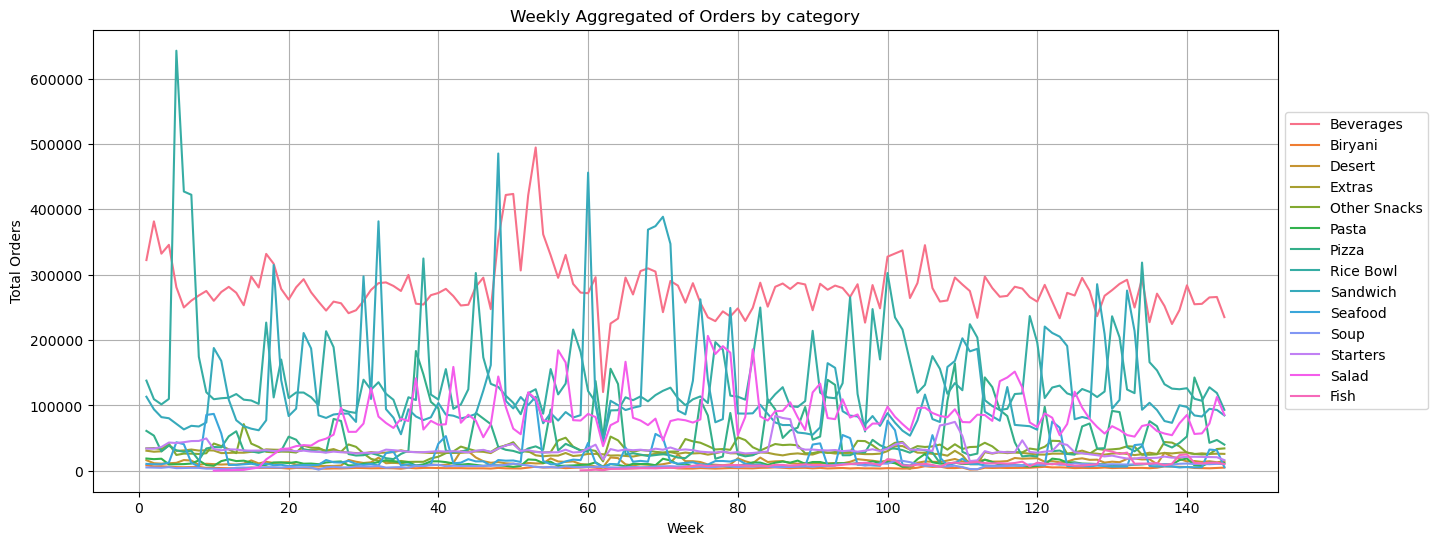

cuisine


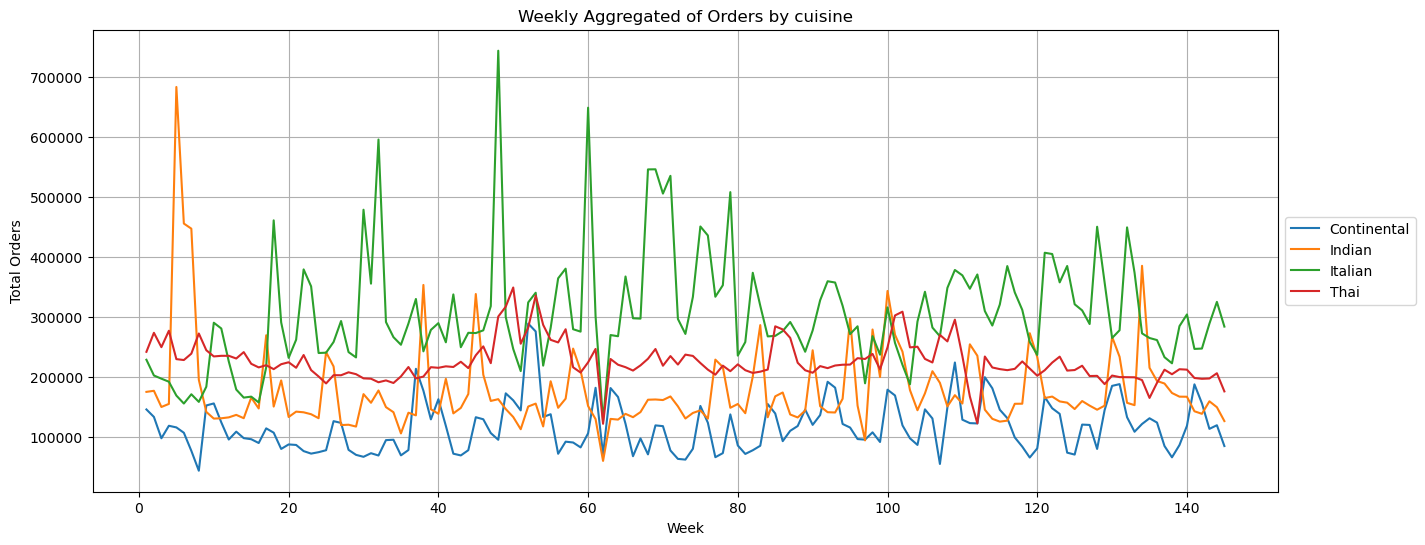

In [7]:
df_categorical = train.select_dtypes('object').astype('category')

for cat in df_categorical.columns: 
    
    print(cat)
    
    plot_categoricals(train,cat,np.sum)

In [ ]:
train

emailer_for_promotion


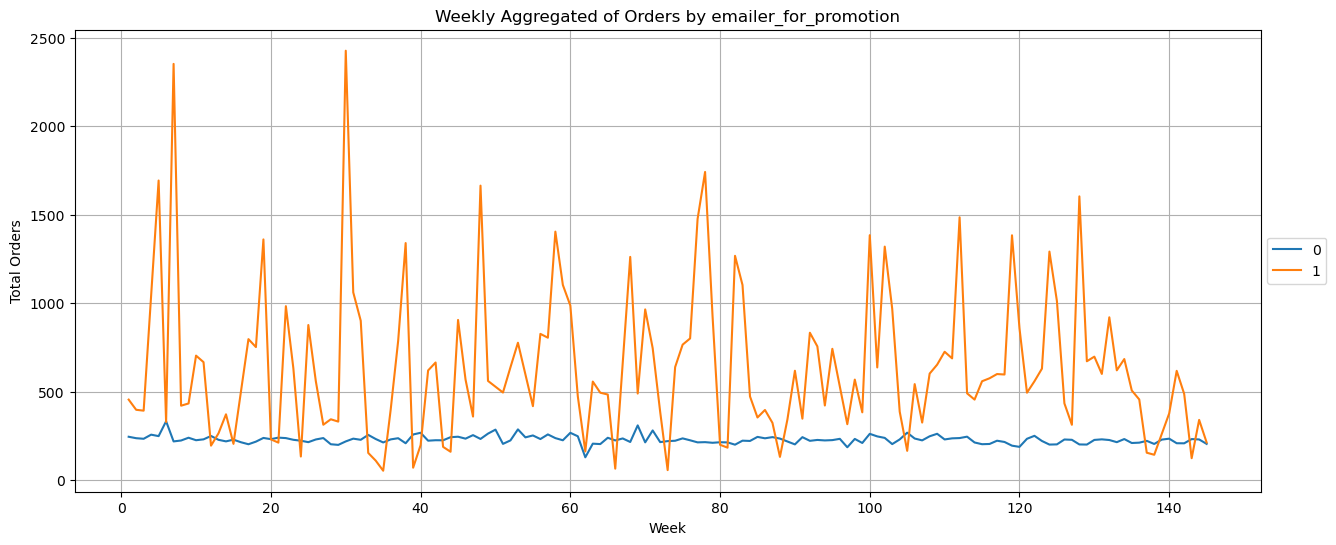

homepage_featured


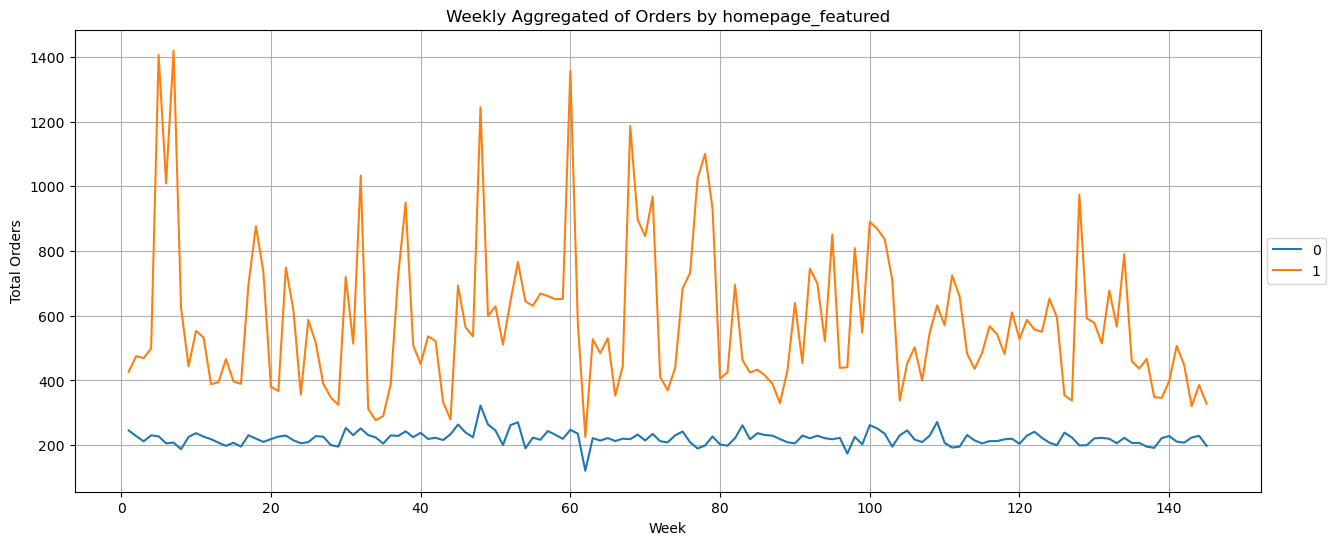

In [10]:
#plotting featured items vs non featured 

featured_items = ['emailer_for_promotion','homepage_featured']

for col in featured_items: 
    print(col)
    
    plot_categoricals(train,col,np.mean);

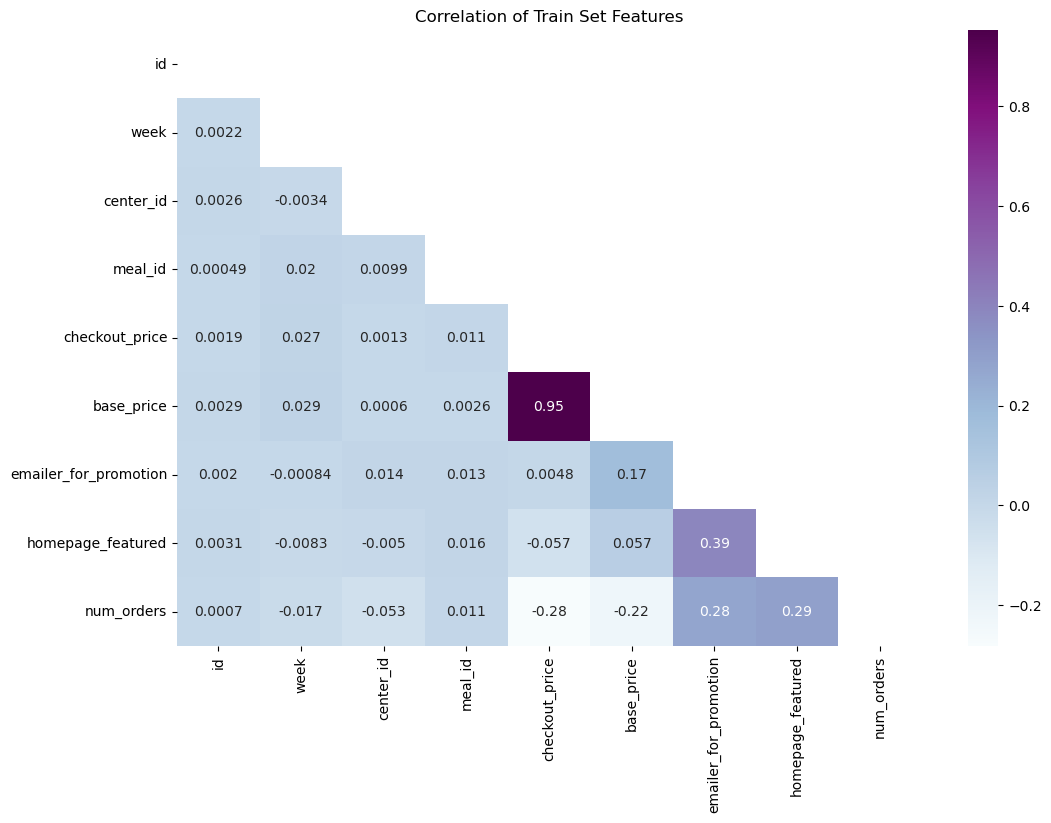

In [11]:
train_corr = train.select_dtypes(include=[int,float]).corr()
                                 
mask = np.triu(np.ones_like(train_corr))
 
fig, ax = plt.subplots(figsize=(12,8))                                 

sns.heatmap(train_corr,mask=mask,ax=ax,annot=True, cmap = 'BuPu')
                                 
ax.set_title('Correlation of Train Set Features')
                                 
plt.show()

            Discount  base_price
Discount    1.000000    0.075586
base_price  0.075586    1.000000


Text(0.5, 1.0, ' Discount % vs Demand')

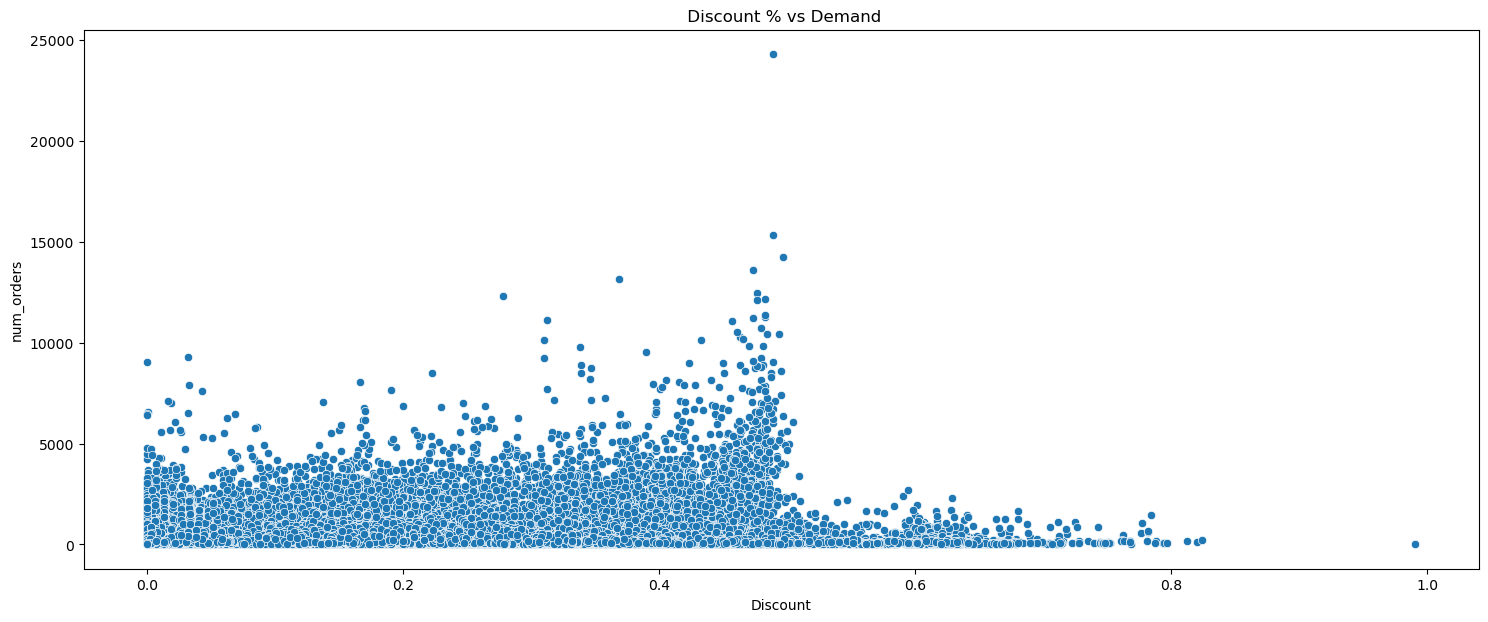

In [12]:
#Intenta crear una función de "descuento" para reducir la multicolinealidad en el precio base y el precio de compra.

train['Discount'] = (train.base_price - train.checkout_price) / train.base_price

#repeat for test set
test['Discount'] = (test.base_price - test.checkout_price) / test.base_price

train['Discount'] = train['Discount'].round(4).abs()

test['Discount'] = test['Discount'].round(4).abs()

print(train[['Discount','base_price']].corr(method='pearson'))

sns.scatterplot(train, x='Discount',y='num_orders')

plt.title(' Discount % vs Demand')

Parece que al crear una función de descuento, vemos que muestra cierta correlación con las promociones y una pequeña cantidad con la demanda.

Al eliminar la columna de precio de pago, espero que el descuento sirva como una función más sólida.

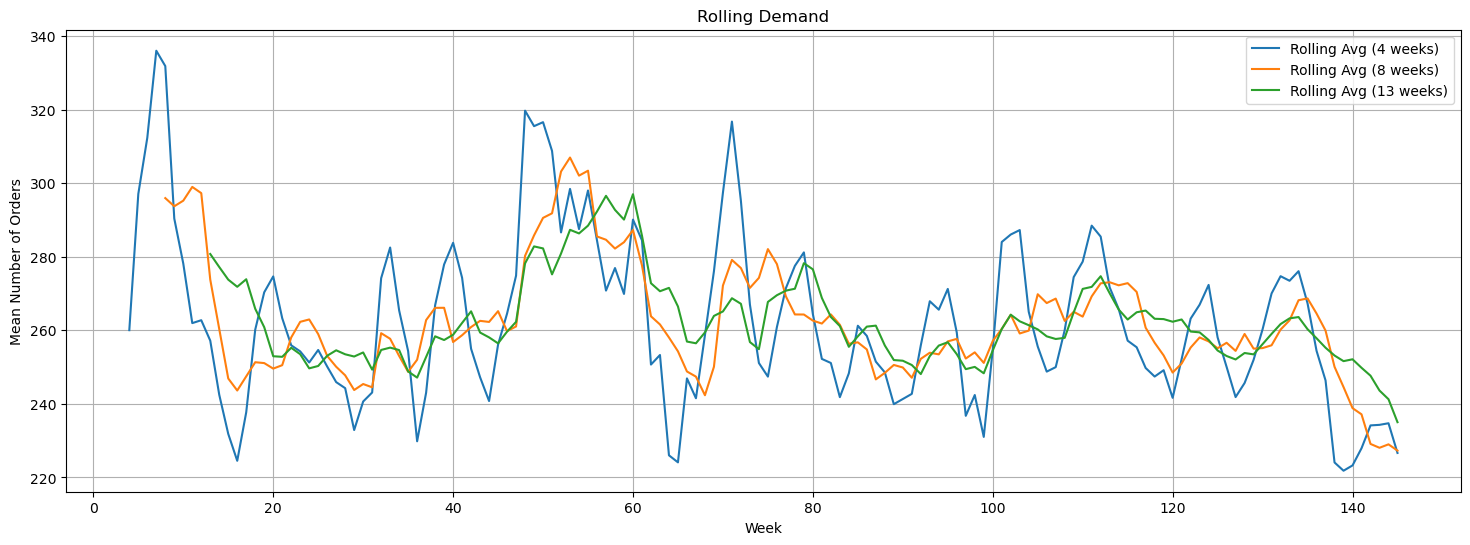

In [13]:
# Calculate weekly demand
weekly_demand = train.groupby('week')['num_orders'].mean().reset_index()

# Calculate rolling averages and add them to the DataFrame
weekly_demand['rolling_4'] = weekly_demand['num_orders'].rolling(window=4).mean()
weekly_demand['rolling_8'] = weekly_demand['num_orders'].rolling(window=8).mean()
weekly_demand['rolling_13'] = weekly_demand['num_orders'].rolling(window=13).mean()

# Plot the rolling averages
plt.figure(figsize=(18, 6))
#plt.plot(weekly_demand['week'], weekly_demand['num_orders'], label='Weekly Demand')
plt.plot(weekly_demand['week'], weekly_demand['rolling_4'], label='Rolling Avg (4 weeks)')
plt.plot(weekly_demand['week'], weekly_demand['rolling_8'], label='Rolling Avg (8 weeks)')
plt.plot(weekly_demand['week'], weekly_demand['rolling_13'], label='Rolling Avg (13 weeks)')

plt.title('Rolling Demand')
plt.xlabel('Week')
plt.ylabel('Mean Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

## `Feature Engeneering`

In [14]:
train = pd.read_csv('https://github.com/narencastellon/Serie-de-tiempo-con-Machine-Learning/raw/refs/heads/main/Data/delivery_company-Train.csv')

test = pd.read_csv('https://raw.githubusercontent.com/narencastellon/Serie-de-tiempo-con-Machine-Learning/refs/heads/main/Data/delivery_company-test.csv')

In [15]:
entre = train.drop(columns= ["id", "center_id", "meal_id", "emailer_for_promotion", "homepage_featured"])
prueba = test.drop(columns= ["id", "center_id", "meal_id", "emailer_for_promotion", "homepage_featured"])

In [ ]:
#train.set_index("week", inplace = True)

### Seleccionar variables

In [16]:
train_avg = entre.groupby('week')[['num_orders', 'checkout_price', 'base_price']].mean()
train_avg

,num_orders,checkout_price,base_price
week,,,
1,271.136550,330.530205,348.516537
2,271.783149,323.926944,347.299448
3,239.828217,327.202580,347.827544
4,257.365524,330.160502,348.372066
5,419.263729,315.194676,350.148709
...,...,...,...
141,237.891511,347.367882,358.118737
142,228.431439,347.298610,357.043981
143,229.932224,342.346188,361.157256


## `Estacionariedad`

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Prueba Dickey Fuller
from statsmodels.tsa.stattools import adfuller
from numpy import log
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05: # P - Values
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [18]:
Augmented_Dickey_Fuller_Test_func(train_avg["num_orders"],"Food - Delivery")

Resultados de la prueba de Dickey-Fuller para columna: Food - Delivery
Test Statistic                         -3.126080
p-value                                 0.024682
No Lags Used                            9.000000
Número de observaciones utilizadas    135.000000
Critical Value (1%)                    -3.479743
Critical Value (5%)                    -2.883198
Critical Value (10%)                   -2.578320
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


In [19]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Gráfico de analisys de Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

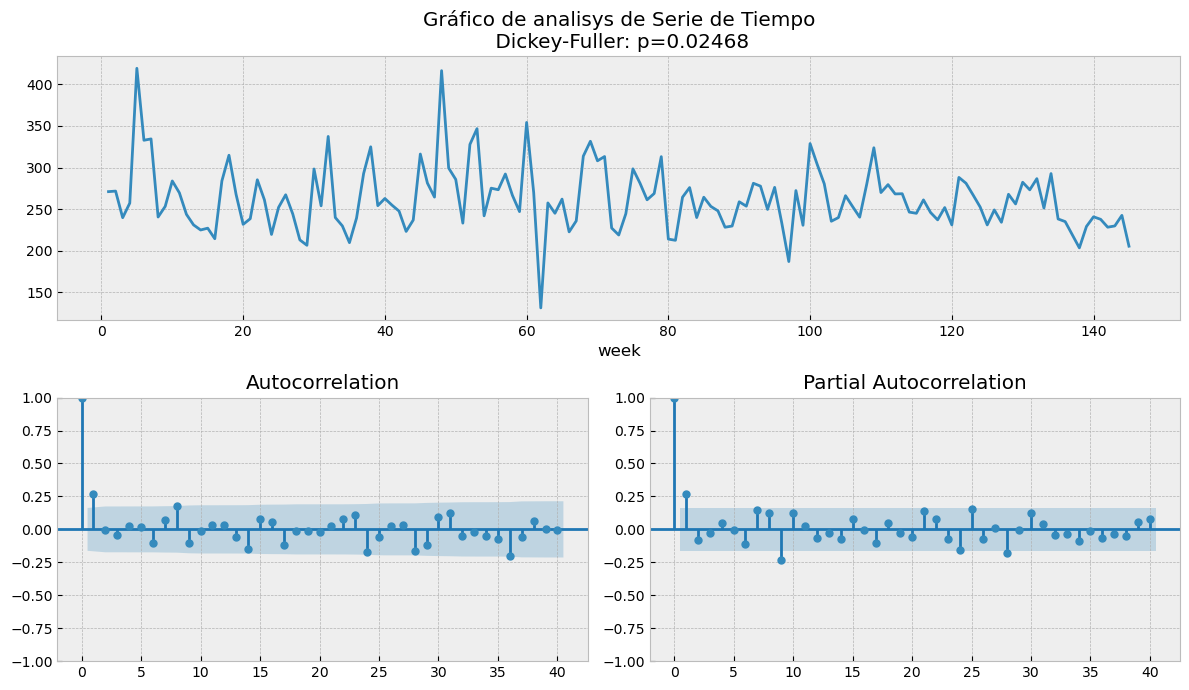

In [20]:
tsplot(train_avg["num_orders"], lags = 40);

Recordar:

- El grafico de ACF, nos sirve para identificar los terminos del modelo MA.

- El grafico de PACF, nos sirve para identificar los terminos del Modelo AR.

## `GridSearch del Modelo ARMA`

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# Supongamos que tienes una serie temporal llamada 'y'
# y = tu_serie_temporal

# Rango de valores para p y q
p_range = range(0, 5)
q_range = range(0, 5)

# Guardar resultados
resultados = []

for p in p_range:
    for q in q_range:
        if p == 0 and q == 0:
            continue  # ARMA(0,0) no tiene sentido
        try:
            modelo = ARIMA(train_avg["num_orders"], order=(p, 0, q))
            resultado = modelo.fit()
            resultados.append({
                'p': p,
                'q': q,
                'AIC': resultado.aic,
                'BIC': resultado.bic
            })
        except:
            continue

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)


In [22]:
# Ordenar por AIC
print("Top modelos por AIC:")
print(df_resultados.sort_values('AIC').head())

# Ordenar por BIC
print("\nTop modelos por BIC:")
print(df_resultados.sort_values('BIC').head())


Top modelos por AIC:
    p  q          AIC          BIC
16  3  2  1461.485343  1482.322479
12  2  3  1462.038847  1482.875983
21  4  2  1463.018367  1486.832237
13  2  4  1463.478554  1487.292424
17  3  3  1463.528733  1487.342603

Top modelos por BIC:
   p  q          AIC          BIC
0  0  1  1466.834389  1475.764590
4  1  0  1467.439608  1476.369809
9  2  0  1468.553691  1480.460626
1  0  2  1468.720361  1480.627296
5  1  1  1468.753888  1480.660823


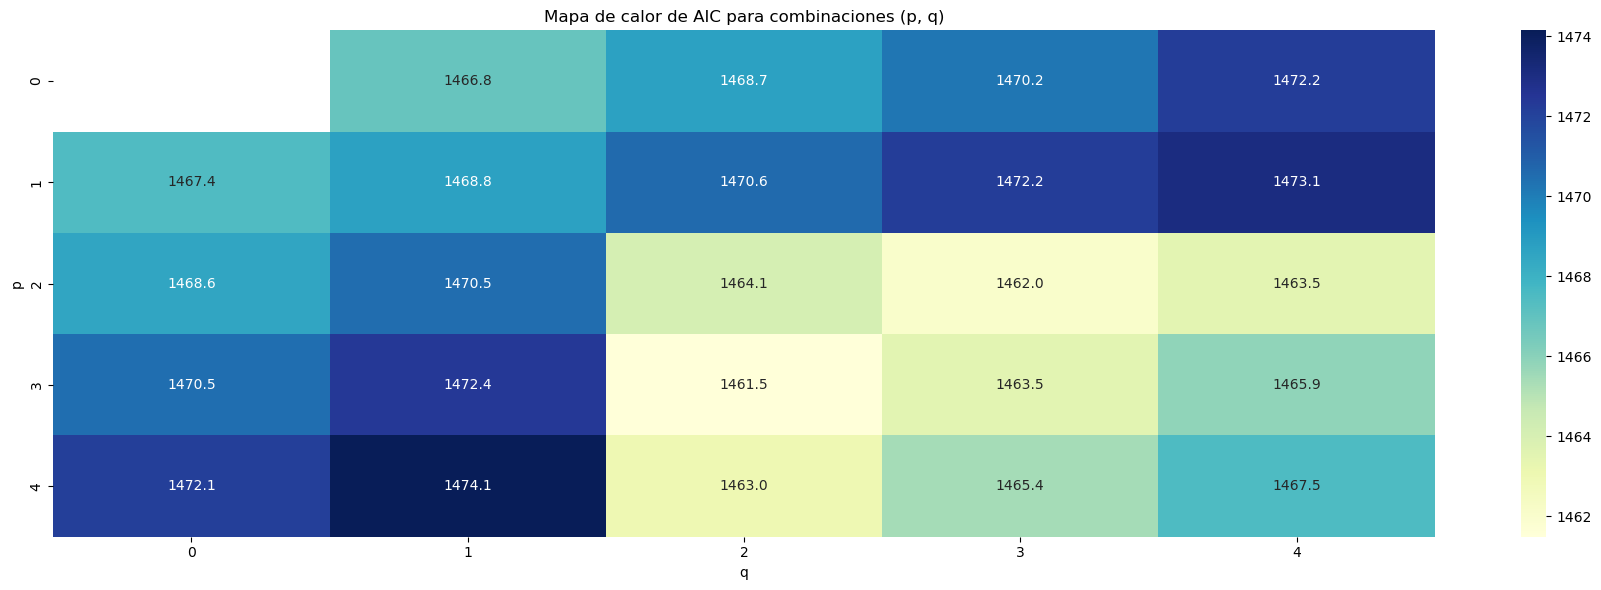

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_resultados.pivot(index='p', columns='q', values='AIC')
plt.figure(figsize=(18, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Mapa de calor de AIC para combinaciones (p, q)")
plt.xlabel("q")
plt.ylabel("p")
plt.tight_layout()
plt.show()

## `Modelo ARMA`

- Utilizamos la metrica AIC

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(train_avg["num_orders"], order = (2,0,2), )  

# Entrenar el modelo
arma_fit = model.fit()

# Resumen del Modelo
print(arma_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                  145
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -726.034
Date:                Wed, 09 Jul 2025   AIC                           1464.068
Time:                        19:52:48   BIC                           1481.928
Sample:                             0   HQIC                          1471.325
                                - 145                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        261.8906      3.858     67.889      0.000     254.330     269.451
ar.L1         -0.2169      0.073     -2.963      0.003      -0.360      -0.073
ar.L2         -0.8691      0.061    -14.143      0.0

## `Residuales del Model`

Revisar los residuales del modelo

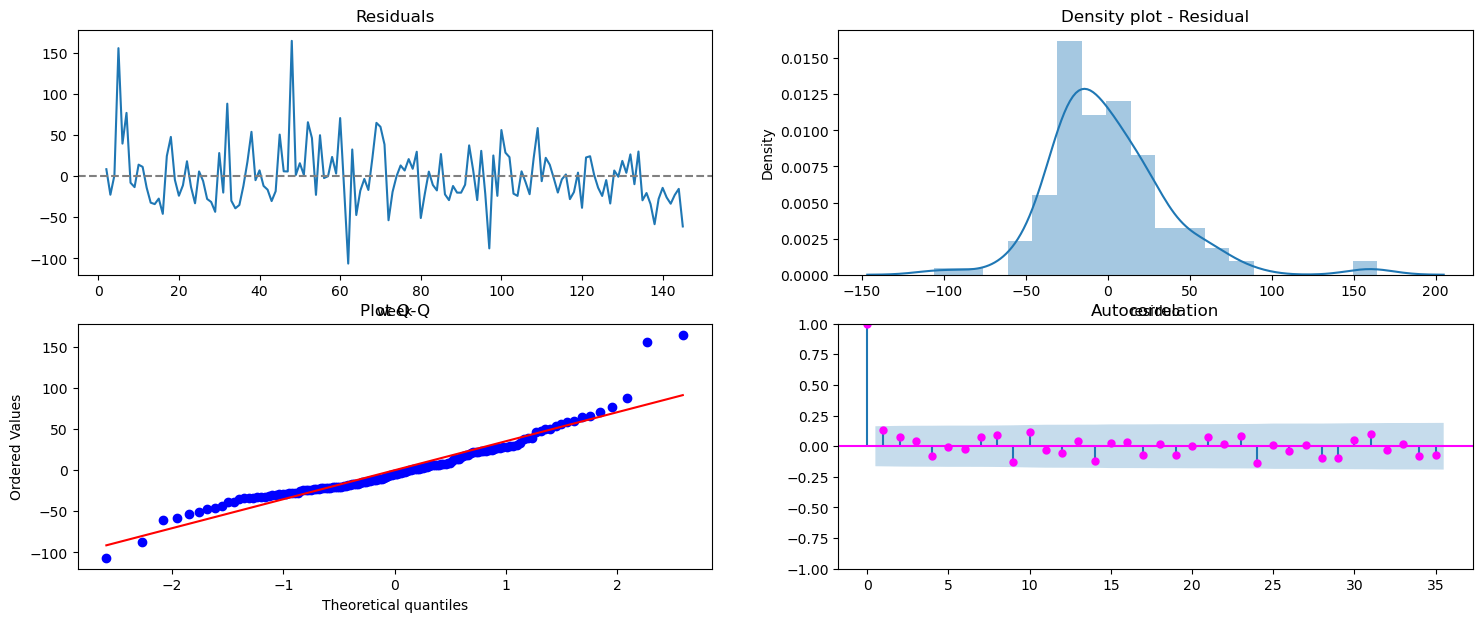

In [33]:
import scipy.stats as stats

residuales =pd.DataFrame(arma_fit.resid.iloc[1:], columns = ["residuo"])

fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residuales["residuo"].plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");
axs[0,0].axhline(0, linestyle='--', color='gray')

# plot
sns.distplot(residuales["residuo"], ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residuales["residuo"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residuales["residuo"],  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

- Tarea: Verificar usando la `prueba Ljung Box` para conocer si los residuales son `Ruido Blanco`.

### `Forecast`

In [34]:
# forecast = arima.forecast(steps = 5)
forecast = arma_fit.forecast(steps = 15)
forecast

145    251.940964
146    257.168271
147    271.561875
148    263.897509
149    253.049943
150    262.063413
151    269.536535
152    260.082301
153    255.637515
154    264.818122
155    266.690293
156    258.305373
157    258.496535
158    265.742481
159    264.005048
Name: predicted_mean, dtype: float64

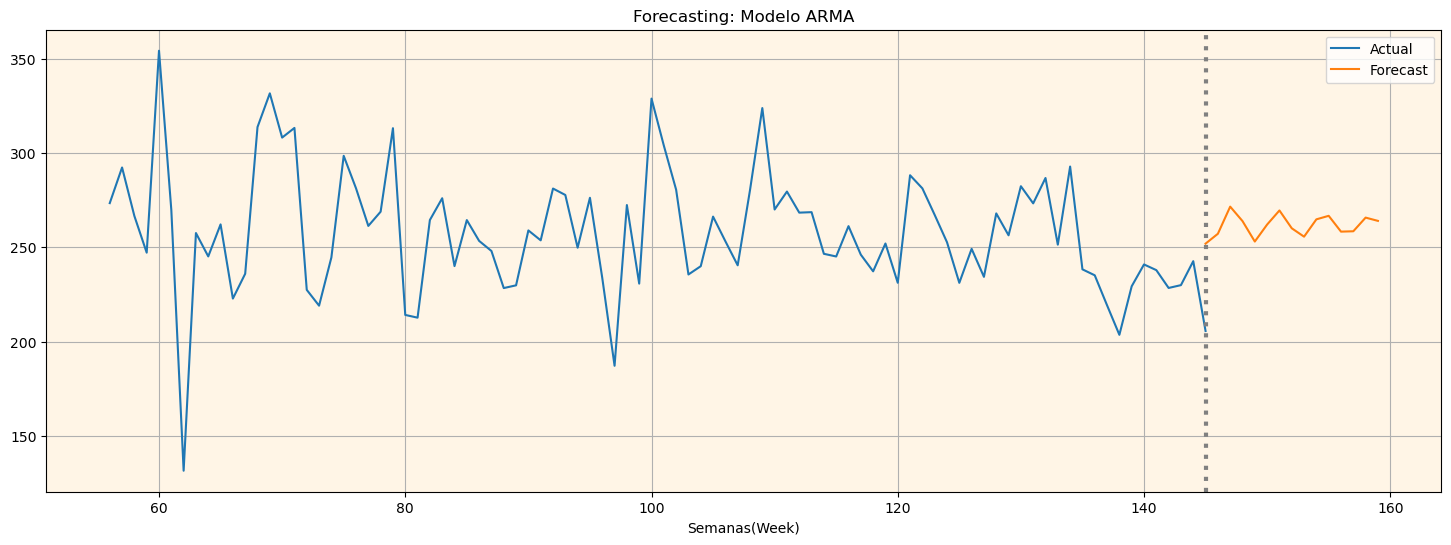

In [35]:
# plot forcasting
plt.figure(figsize=(18,6))
#plt.gca().set_facecolor('#f0f8ff')  # Un tono azul claro, tipo “AliceBlue”
plt.gca().set_facecolor('#fff5e6')  
#plt.gca().set_facecolor('#e6f7ff')

plt.plot(train_avg["num_orders"][-90:], label='Actual')
#plt.plot(weekly_venta_log[-90:], label='Actual')
plt.plot(forecast, label='Forecast')


# Agregar etiquetas y anotaciones
plt.xlabel("Semanas(Week)")
plt.axvline(145, color='gray', linestyle=':', linewidth= 3)
plt.title('Forecasting: Modelo ARMA', )
plt.legend()
plt.grid()
plt.show()

### `Evaluar el modelo`

In [36]:
# split to train and test
train = train_avg[:int(0.9*len(train_avg))]
test = train_avg[int(0.9*len(train_avg)):]

train.shape, test.shape

((130, 3), (15, 3))

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

# train ARIMA
arma_model2 = ARIMA(train["num_orders"], order=(3,0,2),)
arma_fit2 = arma_model2.fit()
arma_pred2 = arma_fit2.forecast(steps= len(test))


#  RMSE
arma_rmse2 = np.sqrt(mean_squared_error(test["num_orders"], arma_pred2))

print(f'Modelo MA RMSE: {arma_rmse2}')

Modelo MA RMSE: 34.34845853897439


## Forecasting

In [38]:
arma_pred2 = arma_fit2.forecast(steps= 15)
arma_pred2

130    269.341476
131    263.845313
132    262.634558
133    265.657957
134    265.660508
135    262.786791
136    263.474557
137    265.976627
138    264.727303
139    262.705860
140    264.359793
141    265.835816
142    263.938678
143    263.028926
144    265.014145
Name: predicted_mean, dtype: float64

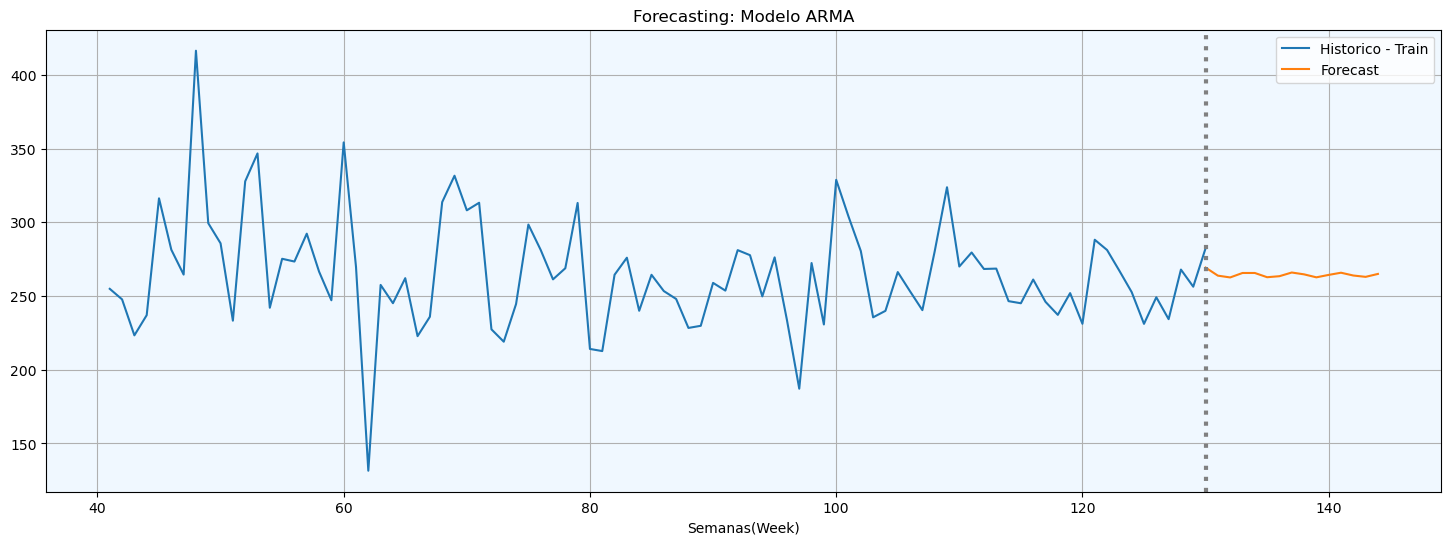

In [39]:
# Visualizar Forecast

plt.figure(figsize=(18,6))
plt.gca().set_facecolor('#f0f8ff')  # Un tono azul claro, tipo “AliceBlue”
plt.plot(train['num_orders'][-90:], label = "Historico - Train")
#plt.plot(test, label='test')
plt.plot(arma_pred2, label='Forecast')
plt.title('Forecasting: Modelo ARMA')
plt.xlabel("Semanas(Week)")
plt.axvline(130, color='gray', linestyle=':', linewidth= 3)
plt.legend()
plt.grid()
plt.show()

## `Modelo SARMA`

### 🔍 ¿Qué es el modelo SARMA?

**SARMA** significa **Seasonal Autoregressive Moving Average**, o en español: **modelo de medias móviles y autoregresivo estacional**. Es un modelo que combina dos estructuras:

1. **ARMA(p, q)** para capturar la **dinámica de corto plazo**
2. **ARMA estacional (P, Q) con periodo s** para capturar `patrones cíclicos o estacionales` a largo plazo

---

### 📐 Notación completa

Un modelo **SARMA(p, q) × (P, Q)\_s** tiene la forma:

$$
X_t = \mu 
+ \underbrace{\sum_{i=1}^{p} \phi_i X_{t-i}}_{\text{AR(p)}}
+ \underbrace{\sum_{j=1}^{q} \theta_j \varepsilon_{t-j}}_{\text{MA(q)}}
+ \underbrace{\sum_{k=1}^{P} \Phi_k X_{t-ks}}_{\text{SAR(P)}_s}
+ \underbrace{\sum_{\ell=1}^{Q} \Theta_\ell \varepsilon_{t-\ell s}}_{\text{SMA(Q)}_s}
+ \varepsilon_t
$$

### 🧩 Descripción parte por parte:

| Término en la ecuación                                | Significado                                               |
|--------------------------------------------------------|-----------------------------------------------------------|
| $ \mu $                                             | Media constante o término independiente                   |
| $ \sum_{i=1}^{p} \phi_i X_{t-i} $                    | **Componente AR(p)**: depende de valores pasados de la serie |
| $ \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} $        | **Componente MA(q)**: depende de errores pasados          |
| $ \sum_{k=1}^{P} \Phi_k X_{t-ks} $                   | **Componente SAR(P)**: dependencias estacionales de los valores |
| $ \sum_{\ell=1}^{Q} \Theta_\ell \varepsilon_{t-\ell s} $ | **Componente SMA(Q)**: errores estacionales pasados        |
| $ \varepsilon_t $                                   | Error aleatorio en el tiempo actual (ruido blanco)        |

> Recuerda que \( s \) es la frecuencia estacional (por ejemplo, 12 para datos mensuales con estacionalidad anual).



#### Significado de cada componente:

- **$ \phi_i $**: coeficientes AR no estacionales
- **$ \theta_j $**: coeficientes MA no estacionales
- **$ \Phi_k $**: coeficientes AR **estacionales**
- **$\Theta_l $**: coeficientes MA **estacionales**
- **$s$**: periodo estacional (por ejemplo, s=12 para datos mensuales)
- **$ \varepsilon_t $**: ruido blanco

---

### 🧠 ¿Cuándo usar SARMA?

| Situación | ¿SARMA aplica? |
|-----------|----------------|
| Hay autocorrelación en lags cercanos (1, 2, etc.) | ✅ |
| Hay patrones que se repiten cada "s" periodos | ✅ |
| La serie es estacionaria o puede convertirse en ella | ✅ |
| Se requiere pronóstico de corto **y** largo plazo | ✅ |


---

### 📊 Resumen visual de la estructura

| Componente        | Efecto                           | Orden         | Frecuencia    |
|------------------|----------------------------------|---------------|----------------|
| AR(p)            | Dependencia de corto plazo       | p             | Lag = 1, 2, … |
| MA(q)            | Errores de corto plazo           | q             | Lag = 1, 2, … |
| **SAR(P)**       | Dependencia de largo plazo       | P             | Lag múltiplos de s |
| **SMA(Q)**       | Errores de largo plazo estacionales | Q          | Lag múltiplos de s |



In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarma_model= SARIMAX(train["num_orders"], order=(2,0,2), seasonal_order=(0,0,1,7))
sarma_fit = sarma_model.fit()
print(sarma_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          num_orders   No. Observations:                  130
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 7)   Log Likelihood                -661.784
Date:                             Wed, 09 Jul 2025   AIC                           1335.568
Time:                                     20:02:56   BIC                           1352.774
Sample:                                          0   HQIC                          1342.559
                                             - 130                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0138    6.2e-05   1.63e+04      0.000       1.014       1.014
ar.L2         -0.0138   6.2

## Forecasting

In [47]:
sarma_forecast = sarma_fit.forecast(steps = 15)
sarma_forecast

130    268.650898
131    261.005887
132    262.823604
133    261.369211
134    264.498260
135    263.222002
136    266.484883
137    265.058404
138    264.442129
139    264.433588
140    264.433435
141    264.433398
142    264.433363
143    264.433327
144    264.433292
Name: predicted_mean, dtype: float64

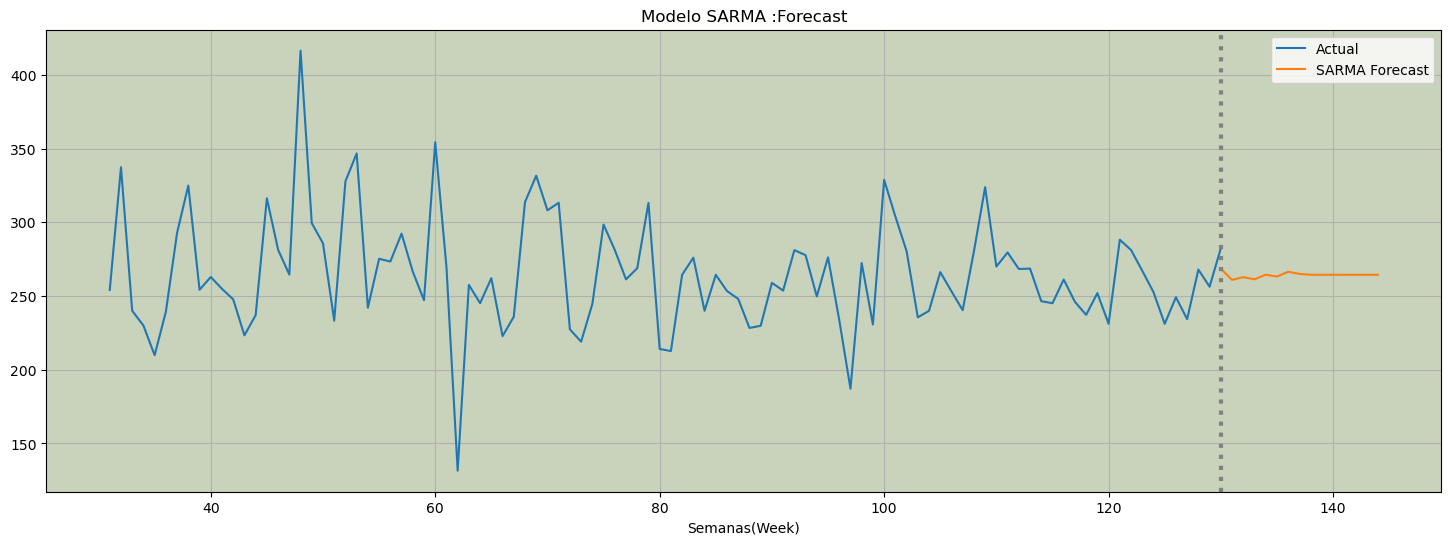

In [49]:
# plot forcast
plt.figure(figsize=(18,6))
plt.gca().set_facecolor("#C9D2BA")
plt.plot(train["num_orders"][-100:], label='Actual')
plt.plot(sarma_forecast, label='SARMA Forecast')
plt.title('Modelo SARMA :Forecast')
plt.xlabel("Semanas(Week)")
plt.axvline(130, color='gray', linestyle=':', linewidth= 3)
plt.legend()
plt.grid()
plt.show()

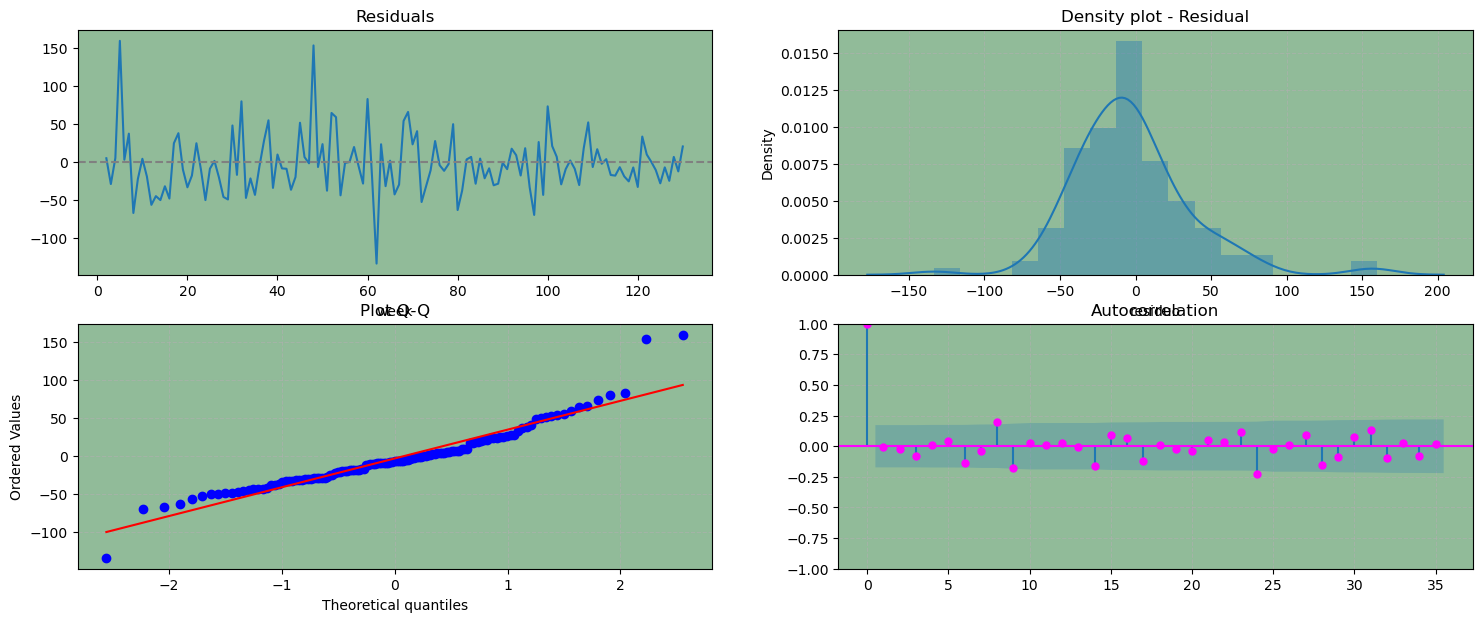

In [50]:
import scipy.stats as stats

residuales_sma =pd.DataFrame(sarma_fit.resid.iloc[1:], columns = ["residuo"])

fig, axs = plt.subplots(nrows=2, ncols=2)

# Cambiar fondo de cada subplot
for ax in axs.flat:
    ax.set_facecolor("#91BB99")  # color amarillo claro
    ax.grid(True, linestyle='--', alpha=0.6)  # grilla activada
    ax.set_axisbelow(True)                   # Grilla detrás de los datos

# plot[1,1]
residuales_sma["residuo"].plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");
axs[0,0].axhline(0, linestyle='--', color='gray')

# plot
sns.distplot(residuales_sma["residuo"], ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residuales_sma["residuo"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residuales_sma["residuo"],  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

## `Modelo SARMAX`

### 🌐 ¿Qué es un modelo SARMA con variables exógenas?

Es un modelo que combina:

1. **ARMA no estacional**: para relaciones de corto plazo.
2. **ARMA estacional**: para capturar patrones cíclicos.
3. **Regresores exógenos**: variables externas que ayudan a explicar la serie.

Este modelo se usa cuando crees que la serie temporal no solo depende de su propio pasado y sus errores, sino también de otras variables influyentes observables (como temperatura, precios, políticas, etc.).

---

### 🧮 Ecuación general del modelo SARMAX(p, q) × (P, Q)\_s + X

$$
X_t = \mu 
+ \underbrace{\sum_{i=1}^{p} \phi_i X_{t-i}}_{\text{AR(p)}}
+ \underbrace{\sum_{j=1}^{q} \theta_j \varepsilon_{t-j}}_{\text{MA(q)}}
+ \underbrace{\sum_{k=1}^{P} \Phi_k X_{t-ks}}_{\text{SAR(P)}_s}
+ \underbrace{\sum_{\ell=1}^{Q} \Theta_\ell \varepsilon_{t-\ell s}}_{\text{SMA(Q)}_s}
+ \underbrace{\boldsymbol{\beta}^\top \mathbf{Z}_t}_{\text{Variables exógenas (X)}}
+ \varepsilon_t
$$

#### Descripción de cada elemento:

| Componente                                   | Significado                                                          |
|----------------------------------------------|----------------------------------------------------------------------|
| $ \mu $                                     | Término constante (intercepto)                                       |
| $ \phi_i X_{t-i} $                          | Componente autoregresivo no estacional (AR)                          |
| $ \theta_j \varepsilon_{t-j} $              | Componente de media móvil no estacional (MA)                         |
| $ \Phi_k X_{t-ks} $                        | Componente autoregresivo estacional (SAR)                            |
| $ \Theta_\ell \varepsilon_{t-\ell s} $      | Componente de media móvil estacional (SMA)                           |
| $ \mathbf{Z}_t $                            | Vector de variables exógenas (observables en el tiempo t)            |
| $ \boldsymbol{\beta} $                      | Coeficientes asociados a las variables exógenas                      |
| $ \varepsilon_t $                           | Término de error aleatorio (“ruido blanco”)                         |


\
> **s** representa la periodicidad estacional: 12 para datos mensuales con ciclo anual, 4 para trimestrales, etc.

---

### 🧠 ¿Por qué usar variables exógenas?

- Mejoran la capacidad de predicción si hay factores externos relevantes
- Ayudan a interpretar dinámicas causales
- Son útiles para escenarios tipo “¿qué pasaría si...?”


In [ ]:
train_avg

In [51]:
# split to train and test
train = train_avg[:int(0.9*len(train_avg))]
test = train_avg[int(0.9*len(train_avg)):]

train.shape, test.shape

((130, 3), (15, 3))

In [52]:
train_avg.columns

Index(['num_orders', 'checkout_price', 'base_price'], dtype='object')

In [59]:
sarmax_model = SARIMAX(train_avg["num_orders"], 
                       exog = train_avg[['checkout_price', 'base_price']], # variable exogena
                       order=(3,0,2),  # parte no estacional
                       seasonal_order=(0,0,1,52)) # SMA(12) con periodo 52

# Se entrena el modelo
sarmax_fit = sarmax_model.fit()

print(sarmax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           num_orders   No. Observations:                  145
Model:             SARIMAX(3, 0, 2)x(0, 0, [1], 52)   Log Likelihood                -720.715
Date:                              Wed, 09 Jul 2025   AIC                           1459.430
Time:                                      20:09:08   BIC                           1486.220
Sample:                                           0   HQIC                          1470.315
                                              - 145                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
checkout_price    -1.8648      0.474     -3.931      0.000      -2.794      -0.935
base_pr

## `Forecasting`

In [60]:
# Realizar forecasting
sarmax_pred = sarma_fit.forecast(steps=len(test), exog = test[["checkout_price", 'base_price']])
#sarmax_pred = sarmax_fit.predict(start = 131, end = 145 , exog = test[["checkout_price"]])
sarmax_pred

130    268.650898
131    261.005887
132    262.823604
133    261.369211
134    264.498260
135    263.222002
136    266.484883
137    265.058404
138    264.442129
139    264.433588
140    264.433435
141    264.433398
142    264.433363
143    264.433327
144    264.433292
Name: predicted_mean, dtype: float64

In [61]:
sarmax_rmse = np.sqrt(mean_squared_error(test["num_orders"], sarmax_pred))
print(f'SARIMA RMSE: {sarmax_rmse}')

SARIMA RMSE: 34.83697648721543


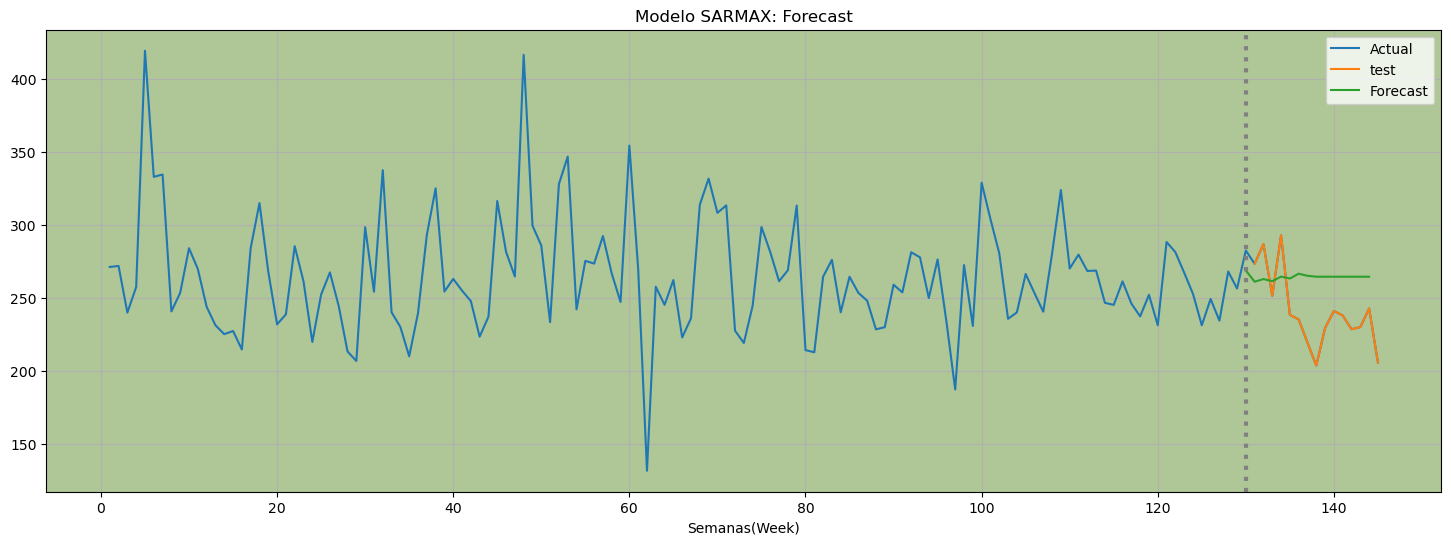

In [62]:
plt.figure(figsize=(18,6))
plt.gca().set_facecolor("#AFC697")
plt.plot(train_avg["num_orders"][-700:], label='Actual')
plt.plot(test["num_orders"], label='test')
plt.plot(sarmax_pred, label='Forecast')
plt.title('Modelo SARMAX: Forecast')
plt.xlabel("Semanas(Week)")
plt.axvline(130, color='gray', linestyle=':', linewidth= 3)
plt.legend()
plt.grid()
plt.show()

## - Agregar estacionalidad y lags

In [ ]:
entre

In [63]:
train_avg = entre.groupby('week')[['num_orders', 'checkout_price', 'base_price']].mean()
train_avg

,num_orders,checkout_price,base_price
week,,,
1,271.136550,330.530205,348.516537
2,271.783149,323.926944,347.299448
3,239.828217,327.202580,347.827544
4,257.365524,330.160502,348.372066
5,419.263729,315.194676,350.148709
...,...,...,...
141,237.891511,347.367882,358.118737
142,228.431439,347.298610,357.043981
143,229.932224,342.346188,361.157256


In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose


result_esta = seasonal_decompose(train_avg["num_orders"], model='additive', period = 52)
train_avg["estacionalidad"] = result_esta.seasonal
train_avg

,num_orders,checkout_price,base_price,estacionalidad
week,,,,
1,271.136550,330.530205,348.516537,41.032597
2,271.783149,323.926944,347.299448,-18.324808
3,239.828217,327.202580,347.827544,-8.676574
4,257.365524,330.160502,348.372066,10.136519
5,419.263729,315.194676,350.148709,41.447073
...,...,...,...,...
141,237.891511,347.367882,358.118737,-3.386257
142,228.431439,347.298610,357.043981,27.235780
143,229.932224,342.346188,361.157256,-10.890922


In [65]:
num_lags = 5
for lag in range(1, num_lags + 1):
    train_avg[f'lag{lag}'] = train_avg['num_orders'].shift(lag)

#train_avg.dropna(inplace = True)

train_avg

,num_orders,checkout_price,base_price,estacionalidad,lag1,lag2,lag3,lag4,lag5
week,,,,,,,,,
1,271.136550,330.530205,348.516537,41.032597,NaN,NaN,NaN,NaN,NaN
2,271.783149,323.926944,347.299448,-18.324808,271.136550,NaN,NaN,NaN,NaN
3,239.828217,327.202580,347.827544,-8.676574,271.783149,271.136550,NaN,NaN,NaN
4,257.365524,330.160502,348.372066,10.136519,239.828217,271.783149,271.136550,NaN,NaN
5,419.263729,315.194676,350.148709,41.447073,257.365524,239.828217,271.783149,271.136550,NaN
...,...,...,...,...,...,...,...,...,...
141,237.891511,347.367882,358.118737,-3.386257,240.903061,229.318390,203.582367,219.232409,235.142988
142,228.431439,347.298610,357.043981,27.235780,237.891511,240.903061,229.318390,203.582367,219.232409
143,229.932224,342.346188,361.157256,-10.890922,228.431439,237.891511,240.903061,229.318390,203.582367


In [66]:
# Lista de tamaños de ventana
windows = [2, 3, 4]

# Calcular promedios móviles para cada tamaño de ventana
for window in windows:
    train_avg[f'moving_average_{window}'] = train_avg['num_orders'].rolling(window=window).mean()

train_avg.dropna(inplace = True)

# Mostrar el DataFrame con los promedios móviles
train_avg

,num_orders,checkout_price,base_price,estacionalidad,lag1,lag2,lag3,lag4,lag5,moving_average_2,moving_average_3,moving_average_4
week,,,,,,,,,,,,
6,332.848911,320.773018,351.573268,2.258510,419.263729,257.365524,239.828217,271.783149,271.136550,376.056320,336.492721,312.326595
7,334.455456,337.139313,350.760787,-2.117099,332.848911,419.263729,257.365524,239.828217,271.783149,333.652183,362.189365,335.983405
8,240.674085,330.035815,346.053654,46.069957,334.455456,332.848911,419.263729,257.365524,239.828217,287.564770,302.659484,331.810545
9,253.413805,323.627001,349.622852,4.001983,240.674085,334.455456,332.848911,419.263729,257.365524,247.043945,276.181115,290.348064
10,283.954180,323.732557,351.293907,-76.282004,253.413805,240.674085,334.455456,332.848911,419.263729,268.683992,259.347357,278.124381
...,...,...,...,...,...,...,...,...,...,...,...,...
141,237.891511,347.367882,358.118737,-3.386257,240.903061,229.318390,203.582367,219.232409,235.142988,239.397286,236.037654,227.923832
142,228.431439,347.298610,357.043981,27.235780,237.891511,240.903061,229.318390,203.582367,219.232409,233.161475,235.742004,234.136100
143,229.932224,342.346188,361.157256,-10.890922,228.431439,237.891511,240.903061,229.318390,203.582367,229.181832,232.085058,234.289559


In [67]:
# split to train and test
train = train_avg[:int(0.9*len(train_avg))]
test = train_avg[int(0.9*len(train_avg)):]

train.shape, test.shape

((126, 12), (14, 12))

In [68]:
train_avg.columns

Index(['num_orders', 'checkout_price', 'base_price', 'estacionalidad', 'lag1',
       'lag2', 'lag3', 'lag4', 'lag5', 'moving_average_2', 'moving_average_3',
       'moving_average_4'],
      dtype='object')

In [81]:
sarmax_model2 = SARIMAX(train["num_orders"], 
                       exog = train[['checkout_price',  'base_price', 'estacionalidad',  'lag1', 'lag2', 'moving_average_2',]], # variable exogena
                       order=(3,0,2),  # parte no estacional
                       seasonal_order=(3,0,2,7)) # Parte estacional SARMA(12) con periodo 52
sarmax_fit2 = sarmax_model2.fit()
sarmax_pred2 = sarmax_fit2.forecast(steps = 14, exog = test[['checkout_price',  'base_price', 'estacionalidad', 'lag1', 'lag2', 'moving_average_2',]])
#sarmax_pred2 = sarmax_fit2.predict(start = 132, end = 145 , exog = test[["checkout_price", 'base_price', 'estacionalidad', 'lag1', 'moving_average_2',]] )  # exog = test[["checkout_price"]]

sarmax_pred2.index = test.index  # opcional: alinear con semanas reales
sarmax_pred2

week
132    286.744200
133    251.378761
134    292.814414
135    238.302975
136    235.142988
137    219.232409
138    203.582367
139    229.318390
140    240.903061
141    237.891511
142    228.431439
143    229.932224
144    242.639915
145    205.607711
Name: predicted_mean, dtype: float64

In [82]:
sarmax_rmse = np.sqrt(mean_squared_error(test["num_orders"], sarmax_pred2))
print(f'SARIMA RMSE: {sarmax_rmse}')

SARIMA RMSE: 1.280104273132114e-13


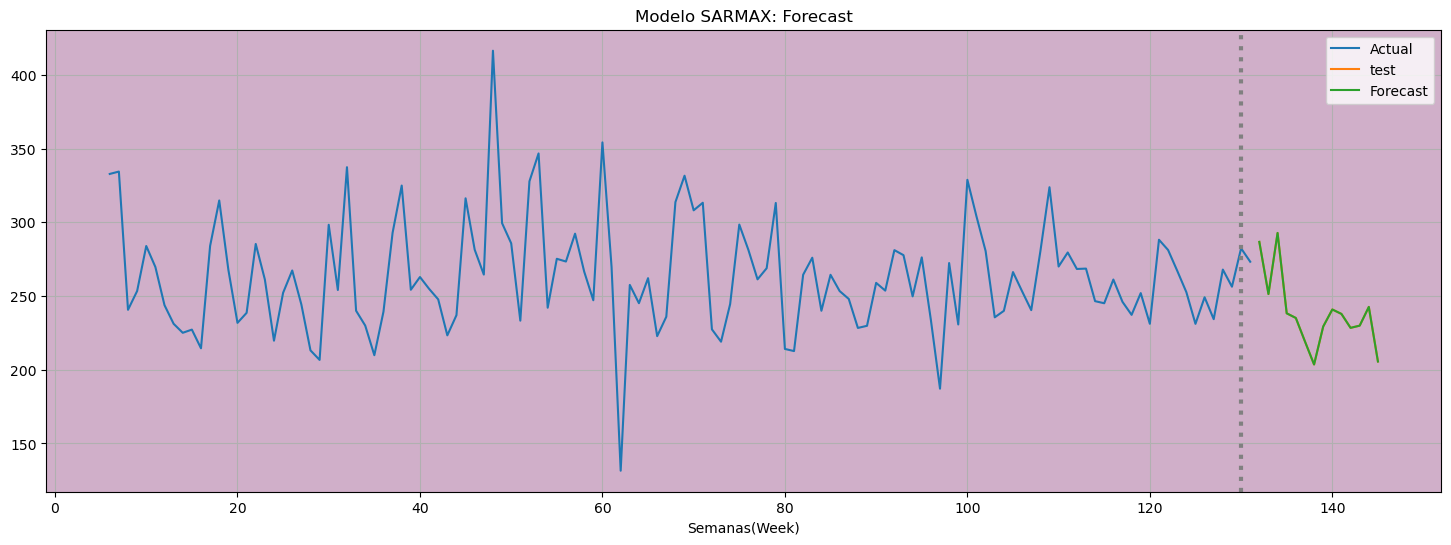

In [83]:
plt.figure(figsize=(18,6))
plt.gca().set_facecolor("#D0AFC9")
plt.plot(train["num_orders"], label='Actual')
plt.plot(test["num_orders"], label='test')
plt.plot(sarmax_pred2, label='Forecast')
plt.title('Modelo SARMAX: Forecast')
plt.xlabel("Semanas(Week)")
plt.axvline(130, color='gray', linestyle=':', linewidth= 3)
plt.legend()
plt.grid()
plt.show()

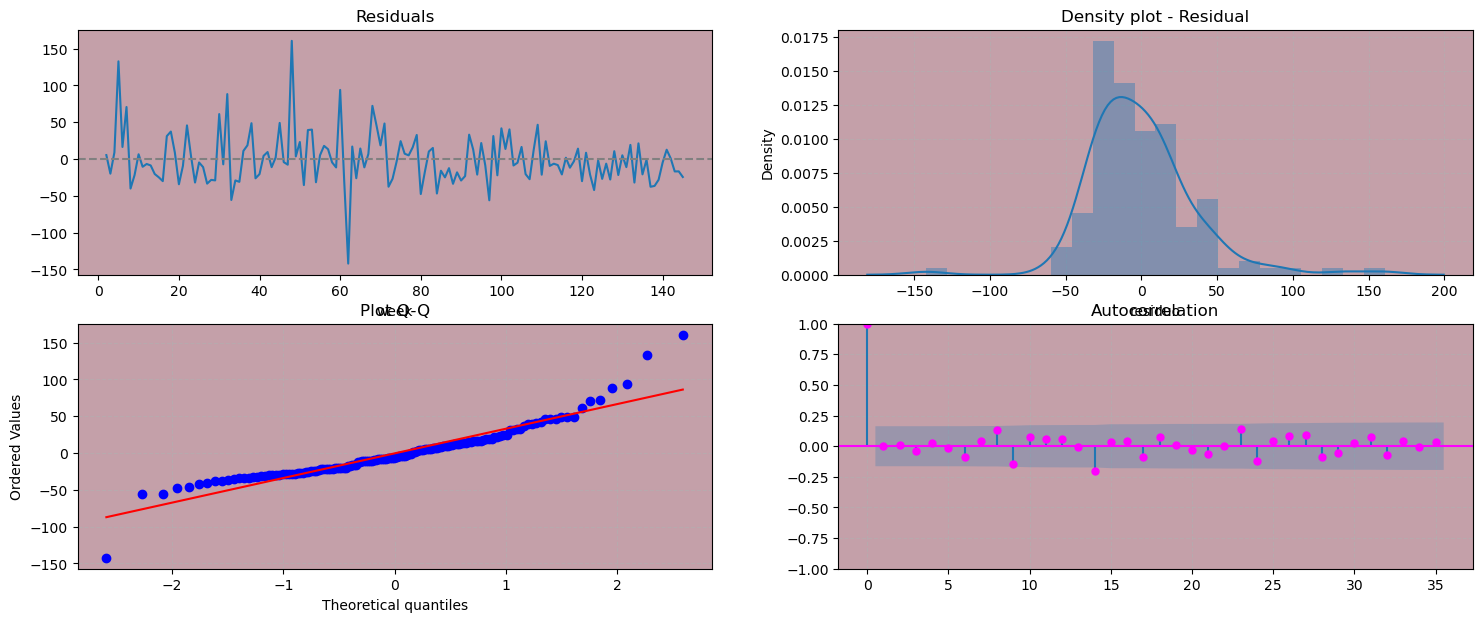

In [84]:
import scipy.stats as stats

residuales_smax =pd.DataFrame(sarmax_fit.resid.iloc[1:], columns = ["residuo"])

fig, axs = plt.subplots(nrows=2, ncols=2)

# Cambiar fondo de cada subplot
for ax in axs.flat:
    ax.set_facecolor("#C4A0A9")  # color amarillo claro
    ax.grid(True, linestyle='--', alpha=0.6)  # grilla activada
    ax.set_axisbelow(True)                   # Grilla detrás de los datos

# plot[1,1]
residuales_smax["residuo"].plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");
axs[0,0].axhline(0, linestyle='--', color='gray')

# plot
sns.distplot(residuales_smax["residuo"], ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residuales_smax["residuo"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residuales_smax["residuo"],  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();